In [86]:
# %matplotlib inline
%matplotlib widget
from hydrophone_data_processing import load, preprocessing, tempmatch
import obspy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import sklearn.metrics as metrics

from obspy.signal.tf_misfit import cwt

class PrecisionDateFormatter(ticker.Formatter):
    """
    Extend the `matplotlib.ticker.Formatter` class to allow for millisecond
    precision when formatting a tick (in days since the epoch) with a
    `~datetime.datetime.strftime` format string.

    """

    def __init__(self, fmt, precision=3, tz=None):
        """
        Parameters
        ----------
        fmt : str
            `~datetime.datetime.strftime` format string.
        """
        from matplotlib.dates import num2date
        if tz is None:
            from matplotlib.dates import _get_rc_timezone
            tz = _get_rc_timezone()
        self.num2date = num2date
        self.fmt = fmt
        self.tz = tz
        self.precision = precision

    def __call__(self, x, pos=0):
        if x == 0:
            raise ValueError("DateFormatter found a value of x=0, which is "
                             "an illegal date; this usually occurs because "
                             "you have not informed the axis that it is "
                             "plotting dates, e.g., with ax.xaxis_date()")

        dt = self.num2date(x, self.tz)
        ms = dt.strftime("%f")[:self.precision]

        return dt.strftime(self.fmt).format(ms=ms)

    def set_tzinfo(self, tz):
        self.tz = tz
        
def minnaert_radius(freq, depth):
    # https://www.engineeringtoolbox.com/specific-heat-capacity-gases-d_159.html
    gamma = 1.405 # taken from website above for 300K
    rho = 997 # kg/m^3
    PA = (rho * 9.8 * depth) + 100000 # kg/(m*s^2)
    # PA/rho => PA(kg*m^-1*s^-2) / rho(kg * m^-3) =? PA(...) * rho(kg^-1 * m^3) => m^2 * s^-2
    return (2 * np.pi * freq)**(-1) * ((3 * gamma * PA)/(rho))**(1/2)

def ideal_gas_n(pressure, volume):
    P = pressure
    V = volume
    R = 8.31446261815324 # J K^−1 mol^−1
    T = 34.75 + 273.15 # K
    n = (P * V)/(R * T)
    return n

def get_mass(pressure, volume):
    n = ideal_gas_n(pressure, volume)
    avogadros_n = 6.0221409e23
    h2_mass = 1.6735575e-27
    return n * avogadros_n * h2_mass

# volume = lambda r: (4/3)*np.pi*r**3

def volume(r):
    return (4/3) * np.pi * r**3

# DATA IMPORT

## import bubble detections from matched filter

In [2]:
bubbles = load.import_bubble_detections('/media/sda/data/borehole/detections/*.csv')
bubbles.reset_index(inplace=True)

# calculate minnaert radius
bubbles['min_radius'] = minnaert_radius(freq=250, depth=15)
bubbles['max_radius'] = minnaert_radius(freq=200, depth=15)
bubbles['mean_radius'] = np.mean([minnaert_radius(freq=200, depth=15), minnaert_radius(freq=250, depth=15)])

# calculate volumes
bubbles['volume_min'] = bubbles.min_radius.apply(volume)
bubbles['volume_max'] = bubbles.max_radius.apply(volume)
bubbles['volume_mean'] = bubbles.mean_radius.apply(volume)

#  calculate mass
bubbles['mass_min'] = bubbles.volume_min.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))
bubbles['mass_max'] = bubbles.volume_max.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))
bubbles['mass_mean'] = bubbles.volume_mean.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))

In [3]:
bubsub = bubbles[bubbles.time.between('2019-05-18','2019-05-19')]

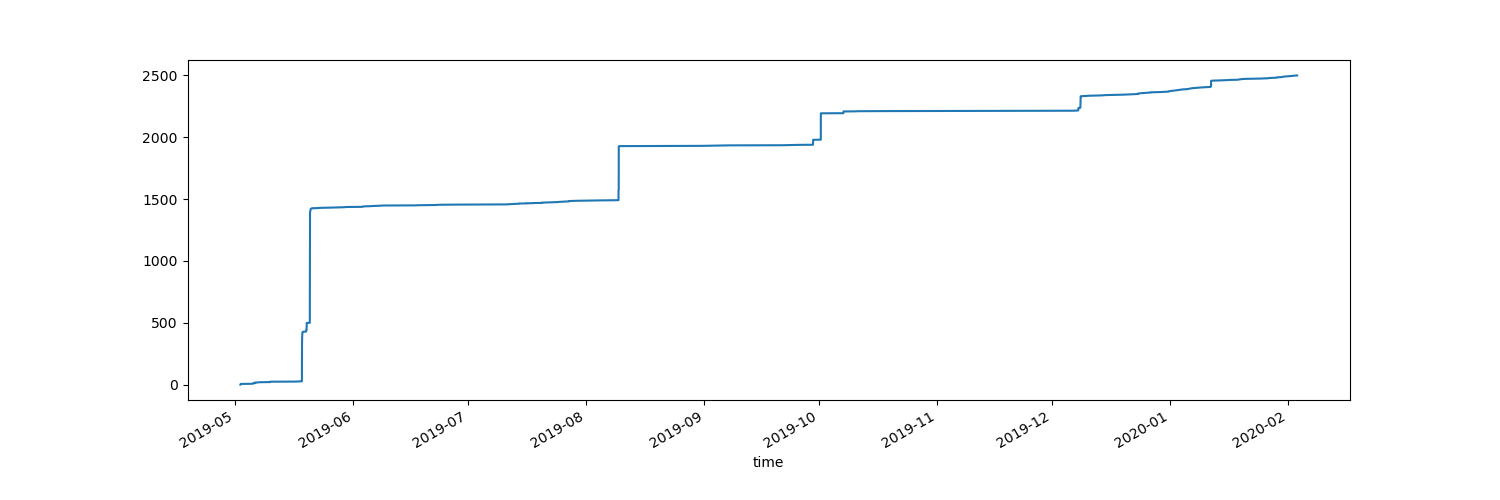

In [78]:
fig, ax = plt.subplots(figsize=(15, 5))
bubbles.set_index('time').ones.cumsum().plot(ax=ax)
# alpha = 
# nt = 400*(1- np.exp(-alpha*t))
event1 = bubbles[bubbles.time.between('2019-05-18 11:30:00', '2019-05-18 14:00:00')].copy()
# event2 = bubbles[bubbles.time.between('2019-05-18 11:30:00', '2019-05-19 12:45:00')].copy()
# event3 = bubbles[bubbles.time.between('2019-05-20 13:35:30', '2019-05-21 14:30:00')].copy()
event3 = bubbles[bubbles.time.between('2019-05-20 13:35:30', '2019-05-20 14:20:00')].copy()
event4 = bubbles[bubbles.time.between('2019-08-09 11:00:00','2019-08-09 12:15:00')].copy()
event5 = bubbles[bubbles.time.between('2019-08-09 13:00:00','2019-08-09 14:00:00')].copy()
event6 = bubbles[bubbles.time.between('2019-09-29 11:00:00','2019-09-29 11:30:00')].copy()
event7 = bubbles[bubbles.time.between('2019-10-01 12:00:00','2019-10-01 13:00:00')].copy()
event8 = bubbles[bubbles.time.between('2019-10-07 10:55:00','2019-10-07 11:05:00')].copy()
event9 = bubbles[bubbles.time.between('2019-12-08 00:00:00','2019-12-08 01:00:00')].copy()
# event9 = bubbles[bubbles.time.between('2019-12-08 00:00:00','2019-12-08 01:00:00')].copy()
event10 = bubbles[bubbles.time.between('2019-12-08 12:50:00','2019-12-08 13:00:00')].copy()
event11 = bubbles[bubbles.time.between('2019-12-08 13:30:00','2019-12-08 15:30:00')].copy()

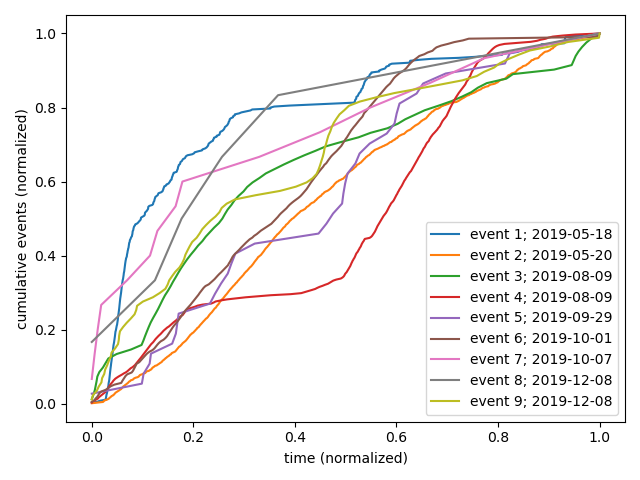

In [74]:
events = [event1
          # , event2
          , event3, event4, event5, event6, event7, event8
          # , event9
          , event10, event11]
fig, ax = plt.subplots()

for n, e in enumerate(events):
    y = e.ones.cumsum()
    y = y/y.max()
    time = e.time
    t = np.array([t.timestamp() for t in time])
    t = (t - t.min())
    t = t/t.max()
    ax.plot(t, y, label='event {n}; {t}'.format(n=n+1, t=time.min().date()))

ax.legend()
ax.set_ylabel('cumulative events (normalized)')
ax.set_xlabel('time (normalized)')

fig.tight_layout()

2193     1
2194     2
2195     3
2196     4
2197     5
2198     6
2199     7
2200     8
2201     9
2202    10
2203    11
2204    12
2205    13
2206    14
2207    15
Name: ones, dtype: int64

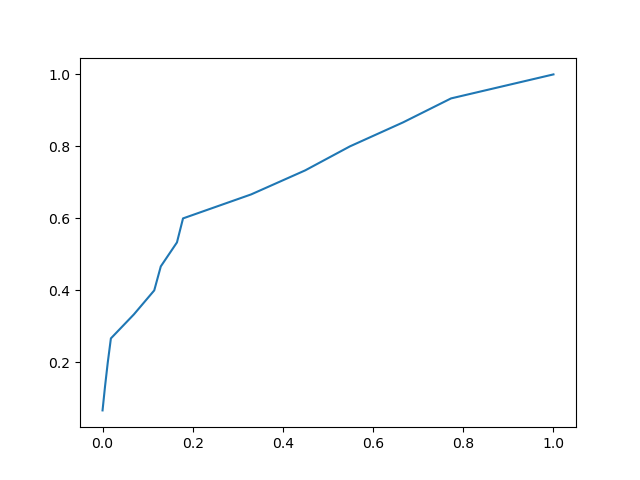

In [77]:
fig, ax = plt.subplots()
e = event8
y = e.ones.cumsum()
y = y/y.max()
time = e.time
t = np.array([t.timestamp() for t in time])
t = (t - t.min())
t = t/t.max()

ax.plot(t, y)
event8.ones.cumsum()

[2.83737902e+03 1.60301882e-04]
A:2837.379017607292 alpha:0.0001603018815661415


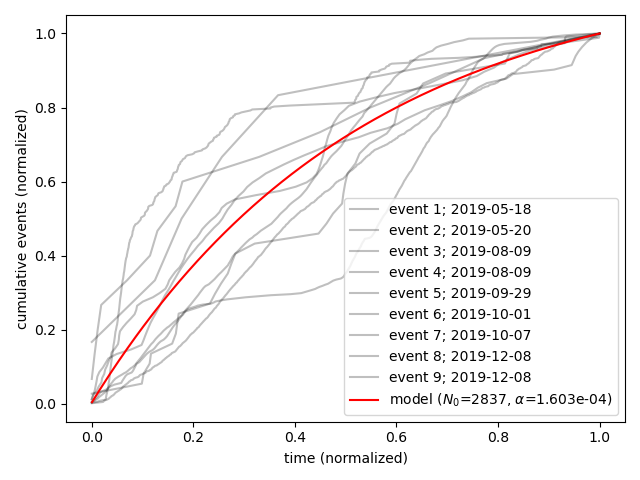

In [132]:
events = [event1
          # , event2
          , event3, event4, event5, event6, event7, event8
          # , event9
          , event10, event11]
fig, ax = plt.subplots()

for n, e in enumerate(events):
    y = e.ones.cumsum()
    y = y/y.max()
    time = e.time
    t = np.array([t.timestamp() for t in time])
    t = (t - t.min())
    t = t/t.max()
    ax.plot(t, y, label='event {n}; {t}'.format(n=n+1, t=time.min().date()), color='black', alpha=0.25)

ax.set_ylabel('cumulative events (normalized)')
ax.set_xlabel('time (normalized)')

from scipy import optimize
def curvefunc(t, a, b):
    return 1+a*(1 - np.exp(-b*t))

e = event3
y = e.set_index('time').ones.cumsum().values
time = e.set_index('time').ones.cumsum().index
t = np.array([t.timestamp() for t in time])
t = t - t.min()
t = t + 1
params, cov = optimize.curve_fit(curvefunc, t, y, p0=(750, 5/10800))
print(params)
print('A:'+str(params[0]),'alpha:'+str(params[1]))
nt_fit = curvefunc(t, a=A, b=alpha)


ax.plot(t/t.max(), nt_fit/nt_fit.max(), color='red', label=r'model ($N_0$={A}'.format(A=int(params[0]))+r', $\alpha$={:.3e})'.format(params[1]))
  
ax.legend()

fig.tight_layout()
fig.savefig('supp_alldegass.pdf', bbox_inches='tight')

In [53]:
event1

,time,similarity,template_id,ones,min_radius,max_radius,mean_radius,volume_min,volume_max,volume_mean,mass_min,mass_max,mass_mean
26,2019-05-18 11:45:45.948000+00:00,0.946315,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
27,2019-05-18 11:47:16.325000+00:00,0.967347,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
28,2019-05-18 11:47:54.450000+00:00,0.961553,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
29,2019-05-18 11:49:19.032000+00:00,0.979752,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
30,2019-05-18 11:49:27.501000+00:00,0.968194,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2019-05-18 13:50:07.760000+00:00,0.985963,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
402,2019-05-18 13:50:23.744000+00:00,0.965736,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
403,2019-05-18 13:53:42.535000+00:00,0.965914,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005
404,2019-05-18 13:56:06.748000+00:00,0.959264,0,1,0.020554,0.025692,0.023123,0.000036,0.000071,0.000052,0.000004,0.000007,0.000005


[3.62105386e+02 7.69797291e-04] [[ 6.89100404e+00 -2.67359119e-05]
 [-2.67359119e-05  2.02730118e-10]]
rmse homemade: 39.6457322487158
rmse scipy.optimize: 33.5724025728551
r2 homemade: 0.8832855267139696
r2 scipy.optimize: 0.9163055477053881


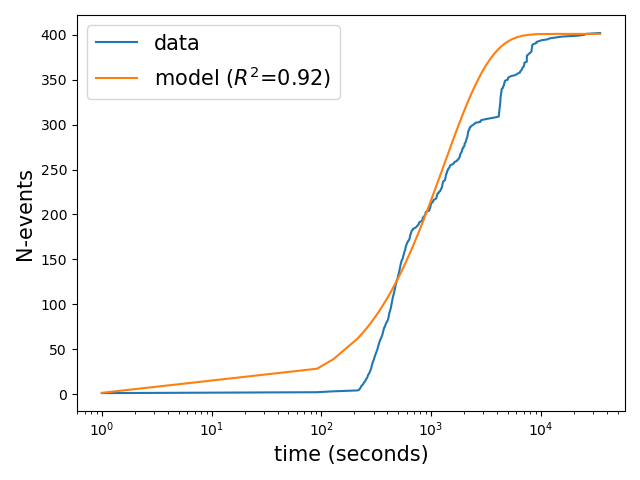

In [95]:
# >>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
# >>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
# (array([ 4.88003249,  0.05531256]),
#  array([[  1.01261314e+01,  -4.31940132e-02],
#         [ -4.31940132e-02,   1.91188656e-04]]))
# # y ≈ 4.88 exp(0.0553 x). much better.

y = bubsub.set_index('time').ones.cumsum().values
time = bubsub.set_index('time').ones.cumsum().index

t = np.array([t.timestamp() for t in time])
t = t - t.min()
t = t + 1
alpha = 1/(t[-1] - t[0])
alpha = 5/10800
nt = 1 + 400*(1 - np.exp(-alpha*t))

fig, ax = plt.subplots()
# ax.plot(t, nt, label='model')
ax.plot(t, y, label='data')

# ax.set_xlim(1e0, 4e4)

from scipy import optimize
def curvefunc(t, a, b):
    return 1+a*(1 - np.exp(-b*t))

params, cov = optimize.curve_fit(curvefunc, t, y, p0=(450, 50/10800))
A, alpha = params
# nt_fit = 1 + A*(1-)
print(params, cov)
# nt_fit = 1 + A*(1 - np.exp(-alpha*t))
# nt_fit = curvefunc(t, a=A, b=alpha)
nt_fit = curvefunc(t, a=400, b=alpha)

# ax.plot(t, nt_fit, label='scipy.optimize')
ax.plot(t, nt_fit, label='model ($R^2$={r2})'.format(r2=round(metrics.r2_score(y_true=y, y_pred=nt_fit),2)))

ax.legend(fontsize=15)
ax.set_xscale('log')

ax.set_xlabel('time (seconds)', fontsize=15)
ax.set_ylabel('N-events', fontsize=15)
fig.tight_layout()
fig.savefig('supp2_model.pdf', bbox_inches='tight')

print('rmse homemade:', np.sqrt(metrics.mean_squared_error(y_true=y, y_pred=nt)))
print('rmse scipy.optimize:', np.sqrt(metrics.mean_squared_error(y_true=y, y_pred=nt_fit)))


print('r2 homemade:', metrics.r2_score(y_true=y, y_pred=nt))
print('r2 scipy.optimize:', metrics.r2_score(y_true=y, y_pred=nt_fit))

[3.62105386e+02 7.69797291e-04] [[ 6.89100404e+00 -2.67359119e-05]
 [-2.67359119e-05  2.02730118e-10]]


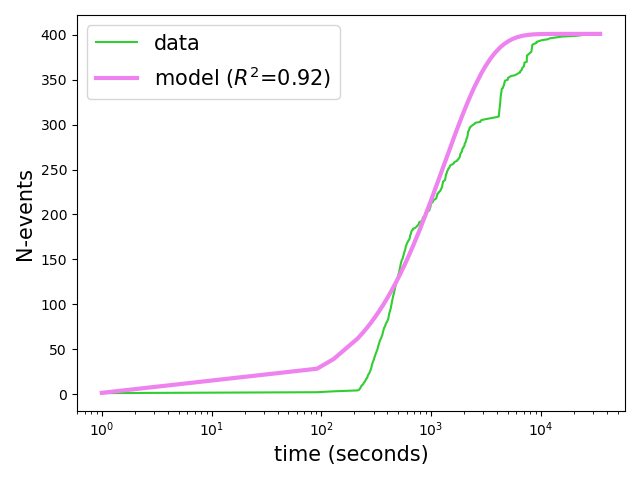

In [100]:
# >>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
# >>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
# (array([ 4.88003249,  0.05531256]),
#  array([[  1.01261314e+01,  -4.31940132e-02],
#         [ -4.31940132e-02,   1.91188656e-04]]))
# # y ≈ 4.88 exp(0.0553 x). much better.

y = bubsub.set_index('time').ones.cumsum().values
time = bubsub.set_index('time').ones.cumsum().index

t = np.array([t.timestamp() for t in time])
t = t - t.min()
t = t + 1

fig, ax = plt.subplots()
ax.plot(t, y, label='data', color='limegreen')


from scipy import optimize
def curvefunc(t, a, b):
    return 1+a*(1 - np.exp(-b*t))

params, cov = optimize.curve_fit(curvefunc, t, y, p0=(450, 50/10800))
A, alpha = params
print(params, cov)
nt_fit = curvefunc(t, a=400, b=alpha)

ax.plot(t, nt_fit, color='violet', linewidth=3, label='model ($R^2$={r2})'.format(r2=round(metrics.r2_score(y_true=y, y_pred=nt_fit),2)))

ax.legend(fontsize=15)
ax.set_xscale('log')

ax.set_xlabel('time (seconds)', fontsize=15)
ax.set_ylabel('N-events', fontsize=15)
fig.tight_layout()
fig.savefig('supp2_model.pdf', bbox_inches='tight')

A:351.439474638252 alpha:0.0008132642671982268
A:2837.379017607292 alpha:0.0001603018815661415
A:84.4274715694224 alpha:0.0029780533336104436
A:153.90632824127408 alpha:0.000639893827233632
A:726.5048540728275 alpha:0.0005083207508989884
A:12.87930683533384 alpha:0.014194988098701683
A:5.476838312938294 alpha:0.008028065406579143
A:91.0993062077335 alpha:0.00039074347057816973
[0.0001603018815661415, 0.00039074347057816973, 0.0005083207508989884, 0.000639893827233632, 0.0008132642671982268, 0.0029780533336104436, 0.008028065406579143, 0.014194988098701683]


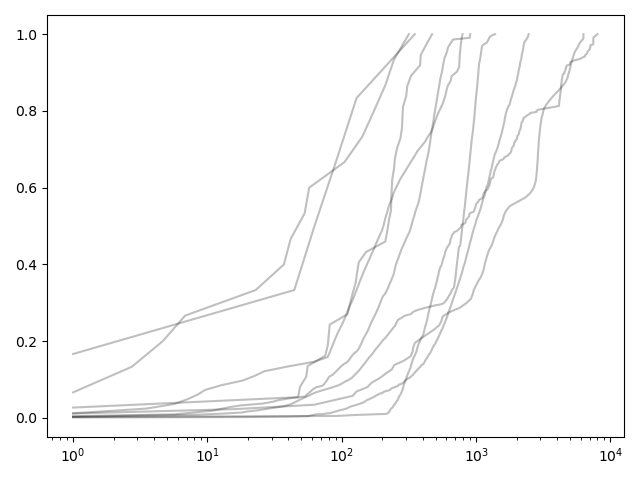

In [48]:
alphas = []
fig, ax = plt.subplots()

for e in events:
    try:
        y = e.set_index('time').ones.cumsum().values
        time = e.set_index('time').ones.cumsum().index

        t = np.array([t.timestamp() for t in time])
        t = t - t.min()
        t = t + 1

        ax.plot(t, y/y.max(), label='data', color='black', alpha=0.25)

        from scipy import optimize
        def curvefunc(t, a, b):
            return 1+a*(1 - np.exp(-b*t))

        params, cov = optimize.curve_fit(curvefunc, t, y, p0=(750, 5/10800))
        A, alpha = params
        print('A:'+str(params[0]),'alpha:'+str(params[1]))
        nt_fit = curvefunc(t, a=A, b=alpha)
        
        alphas.append(alpha)

        # ax.plot(t, nt_fit/nt_fit.max(), label='scipy.optimize')

        # ax.legend(fontsize=15)
        ax.set_xscale('log')
    except RuntimeError:
        pass
    
print(sorted(alphas))
# fig, ax =plt.subplots()
# ax.hist(alphas)
# ax.set_xscale('log')
fig.tight_layout()


In [39]:
t

array([1.00000000e+00, 1.59270000e+01, 6.25660000e+01, 8.66569998e+01,
       1.20453000e+02, 1.28803000e+02, 1.55378000e+02, 1.66858000e+02,
       1.91200000e+02, 2.11002000e+02, 2.35824000e+02, 2.45898000e+02,
       2.90494000e+02, 3.26166000e+02, 3.36033000e+02, 3.40301000e+02,
       3.50075000e+02, 3.88311000e+02, 4.33352000e+02, 4.84277000e+02,
       5.31255000e+02, 5.51868000e+02, 5.62401000e+02, 6.34984000e+02,
       7.58218000e+02, 8.42717000e+02, 9.13647000e+02, 9.41740000e+02,
       9.61292000e+02, 9.97742000e+02, 1.03651700e+03, 1.08775100e+03,
       1.12063100e+03, 1.14556600e+03, 1.16153000e+03, 1.18749200e+03,
       1.21486800e+03, 1.24574200e+03, 1.30096500e+03, 1.33796600e+03,
       1.37036300e+03, 1.41867300e+03, 1.47213600e+03, 1.53508300e+03,
       1.58332600e+03, 1.61178800e+03, 1.67291600e+03, 1.77601600e+03,
       2.03459200e+03, 2.33371300e+03, 2.53105100e+03, 2.66454100e+03,
       2.73962100e+03, 2.78820500e+03, 2.81195000e+03, 2.83088800e+03,
      

[1.03914258e+03 5.76204812e-04] [[ 9.10532351e+01 -7.98300136e-05]
 [-7.98300136e-05  8.36780343e-11]]


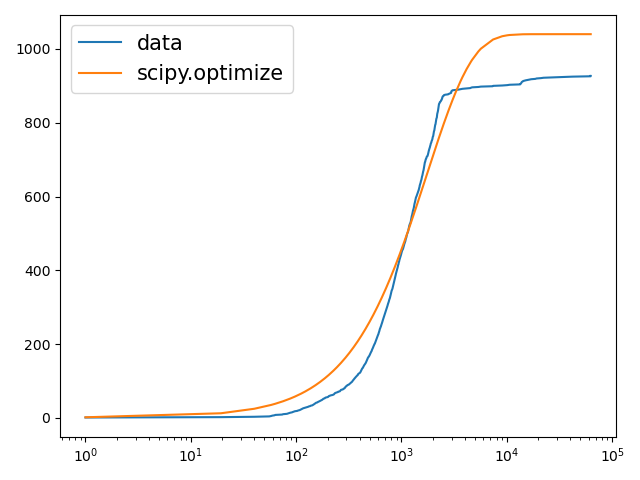

In [27]:
# fig, ax = plt.subplots()

# y = event3.set_index('time').ones.cumsum().values
# time = event3.set_index('time').ones.cumsum().index

# t = np.array([t.timestamp() for t in time])
# t = t - t.min()
# t = t + 1

# ax.plot(t, y, label='data')

# from scipy import optimize
# def curvefunc(t, a, b):
#     return 1+a*(1 - np.exp(-b*t))

# params, cov = optimize.curve_fit(curvefunc, t, y, p0=(750, 5/10800))
# A, alpha = params
# print(params, cov)
# nt_fit = curvefunc(t, a=A, b=alpha)

# ax.plot(t, nt_fit, label='scipy.optimize')

# ax.legend(fontsize=15)
# ax.set_xscale('log')
# fig.tight_layout()

In [15]:
events

[                                time  similarity  template_id  ones  \
 26  2019-05-18 11:45:45.948000+00:00    0.946315            0     1   
 27  2019-05-18 11:47:16.325000+00:00    0.967347            0     1   
 28  2019-05-18 11:47:54.450000+00:00    0.961553            0     1   
 29  2019-05-18 11:49:19.032000+00:00    0.979752            0     1   
 30  2019-05-18 11:49:27.501000+00:00    0.968194            0     1   
 ..                               ...         ...          ...   ...   
 401 2019-05-18 13:50:07.760000+00:00    0.985963            0     1   
 402 2019-05-18 13:50:23.744000+00:00    0.965736            0     1   
 403 2019-05-18 13:53:42.535000+00:00    0.965914            0     1   
 404 2019-05-18 13:56:06.748000+00:00    0.959264            0     1   
 405 2019-05-18 13:59:06.727000+00:00    0.980256            0     1   
 
      min_radius  max_radius  mean_radius  volume_min  volume_max  volume_mean  \
 26     0.020554    0.025692     0.023123    0.00003

In [102]:
t.shape

(402,)

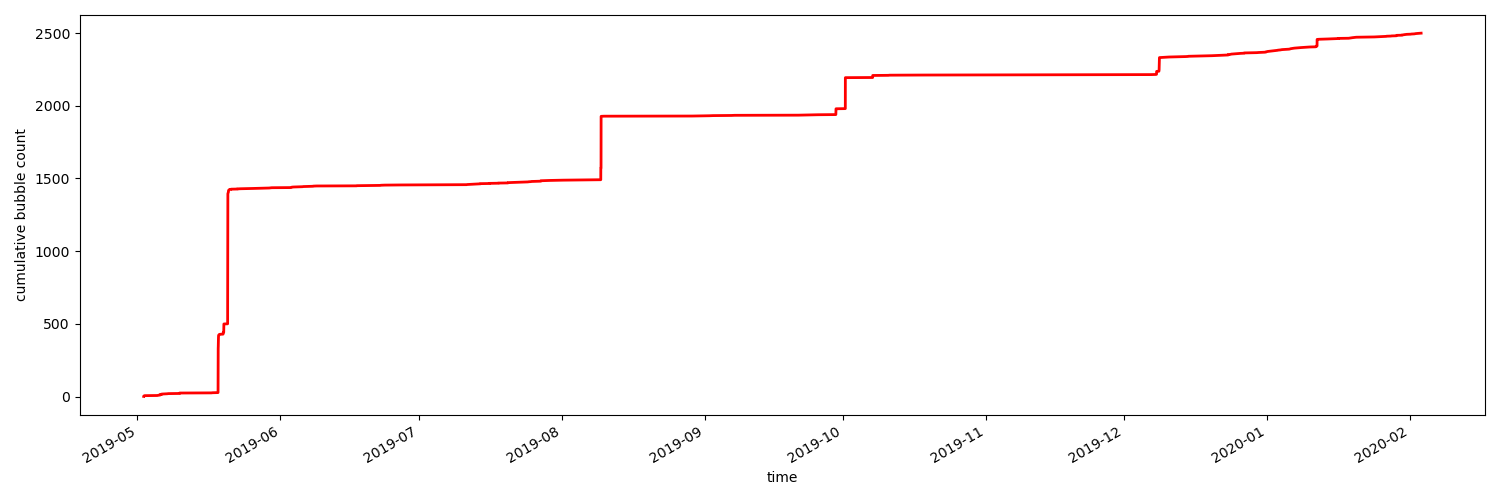

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
bubbles.set_index('time').cumsum().ones.plot(ax=ax, color='red', linewidth=2)
ax.set_ylabel('cumulative bubble count')
fig.tight_layout()

In [4]:
bubbles.time[1] - bubbles.time[0]

Timedelta('0 days 00:00:50.954000')

In [5]:
np.arange(0, bubbles.shape[0], 1)

array([   0,    1,    2, ..., 2496, 2497, 2498])

In [6]:
(6777/60)/60

1.8825

In [7]:
dts = []
deltaT = [0,]
for n in np.arange(0, bubbles.shape[0], 1):
    if n+1 == bubbles.shape[0]:
        break
        
    dt = bubbles.time[n+1] - bubbles.time[n]
    dts.append(dt)
    # deltaT.append(dt.seconds)
    deltaT.append(dt.seconds+dt.microseconds*1e-6)
    
bubbles['TimeDelta'] = dt
bubbles['deltaT_sec'] = deltaT

In [8]:
bubbles.deltaT_sec.hist(log=True, bins=100)

<AxesSubplot:xlabel='time'>

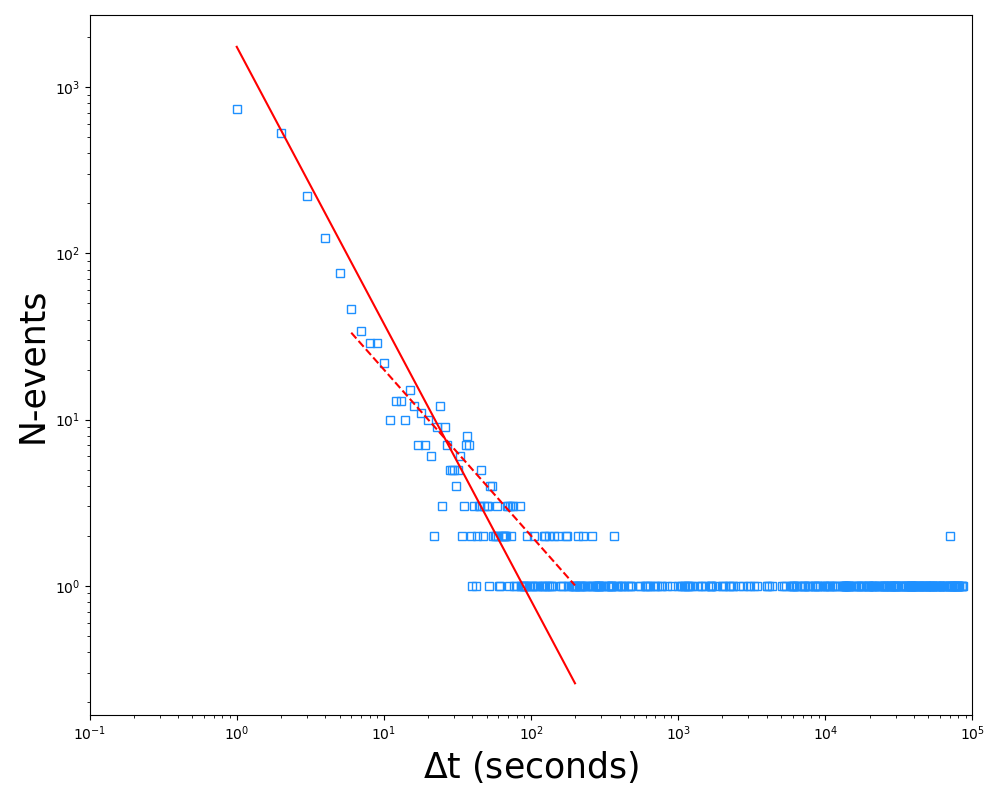

In [200]:
h, e = np.histogram(bubbles.deltaT_sec[1:], bins=np.linspace(0, 100000, 100000) )
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(e[:-1], h, color='dodgerblue', linewidth=0, marker='s', fillstyle='none')
# ax.set_xscale('log')
ax.set_xlim(1e-1, 1e5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('N-events', fontsize=25)
ax.set_xlabel('$\Delta$t (seconds)', fontsize=25)

x = np.arange(1e0, 2e2)
y = 1750*x**(-1.666) # satan number
ax.plot(x, y, color='red')
ax.plot(x[5:], 200*1/x[5:], color='red', linestyle='--')
# ax.plot(h[h<0], color='red', marker='s')

fig.tight_layout()

In [196]:
x

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

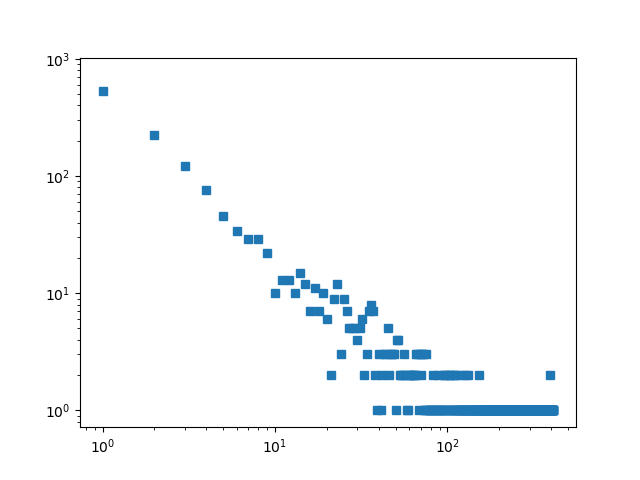

In [50]:
fig, ax = plt.subplots()
ax.plot( h[h>0], marker='s', linewidth=0)
ax.set_yscale('log')
ax.set_xscale('log')

In [10]:
bubbles.deltaT_sec[1:].min()

1.103

In [11]:
bubbles.deltaT_sec[1:].max()

86145.286

In [12]:
e

array([0.00000e+00, 1.00001e+00, 2.00002e+00, ..., 9.99980e+04,
       9.99990e+04, 1.00000e+05])

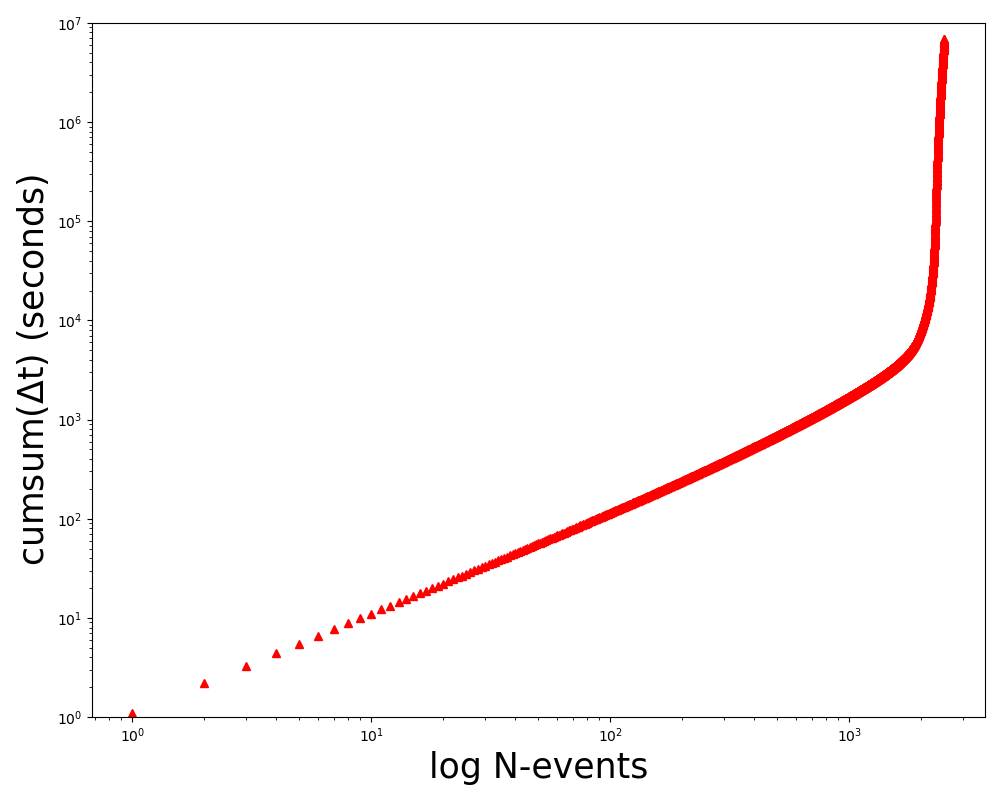

In [21]:
x = bubbles.deltaT_sec[1:].sort_values()
y = x.cumsum()

fig, ax = plt.subplots(figsize=(10, 8))
# ax.plot(x, y, color='red')
ax.plot(np.arange(1, x.shape[0]+1, 1), y, color='red', marker='^', linewidth=0)
# ax.plot([0, 1e5], [0, 1e5])
ax.set_ylim(1e0, 1e7)
# ax.set_xlim(1e-1, 1e5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('cumsum($\Delta$t) (seconds)', fontsize=25)
ax.set_xlabel('log N-events', fontsize=25)
fig.tight_layout()

In [14]:
bubbles.deltaT_sec[1:].sort_values().max()

86145.286

In [15]:
x

828         1.103000
927         1.105000
2412        1.105000
162         1.105000
682         1.105000
            ...     
1471    81387.781000
1932    84342.382999
1472    84685.098000
1432    85224.280000
1456    86145.286000
Name: deltaT_sec, Length: 2498, dtype: float64